# Homework02: 
# Recommender System Using MovieLens Dataset

#### The goal of this homework is making movie recommendations using two basic CF algorithms: K-NN and Matrix Factorization.

In [5]:
#Import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV
from surprise import Dataset
from surprise import Reader
from sklearn.model_selection import KFold
import time as tm
import scipy.stats as spst
import scipy.sparse as spsp
import itertools
%matplotlib inline
df=pd.read_csv('./ml-latest-small/ratings.csv')


In [6]:
reader = Reader(line_format='user item rating', sep=',', skip_lines=3, rating_scale=(1, 5))

### Ratings Dataset

In [7]:
df=pd.read_csv('./ml-latest-small/ratings.csv')
df=df.drop(['timestamp'],axis=1)
data=Dataset.load_from_df(df,reader=reader)

In [8]:
origin_size=len(df.values)
gap=int(origin_size/5)
new_size=np.arange(gap,origin_size,gap)

In [5]:
df.head(6)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0


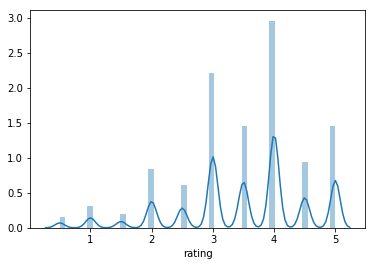

In [6]:
# Display distribution of rating
sns.distplot(df['rating'].fillna(df['rating'].median()))

There are more ratings in score 4 and 3 than that in other scores, showing that most of users are neutralistic. However, some users might rate their favorite movies only 4 stars while some rate it as 5 stars due to personality variance.

# Collaborative Filtering Recommendation Model
## KNN (Self-Implementation)

In [7]:
def trans_arr(result,data):
    arr=np.ones(len(data))
    for index,row in enumerate(data):
        i = int(row[0])-1
        j = int(row[1])-1
        try:
            arr[index]=result[i][j]
        except:
            arr[index]=0
    return arr

def MAE(arr,data):
    return np.mean(np.abs(data[:,-1]-arr))
def RMSE(arr,data):
    return (np.mean((data[:,-1]-arr)**2))**0.5

def get_neighbors(sim,k,i):
    sim[i]=-float('inf')
    return np.argsort(sim)[::-1][:k]
    
def knn_mean(df,k=40):
    n_user = max(df.userId.values)
    n_item = max(df.movieId.values)
    data = df.values[:,:-1]
    mu_user=df.groupby(['userId']).mean().rating.values
    R = np.zeros((n_user,n_item))
    result= np.zeros((n_user,n_item))
    norm_R =np.zeros((n_user,n_item))
    for row in data:
        i = int(row[0])-1
        j = int(row[1])-1
        R[i][j]=row[2]
        norm_R[i][j]=row[2]-mu_user[i]
    sim_matrix = np.corrcoef(R) 
    for i,row in enumerate(R):
        mu=mu_user[i]
        sim=sim_matrix[i]
        k_index=get_neighbors(sim,k,i)
        k_sim=sim[k_index]
        k_nb=norm_R[k_index,:]
        result[i]=(k_sim.T@k_nb/np.sum(k_sim)+mu)
    return result,data

In [8]:
def knn_cv(n_splits=5,k=40,size=origin_size):
    df=pd.read_csv('./ml-latest-small/ratings.csv')
    df=df.iloc[:size]
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 1)
    knn_train_mae=[]
    knn_train_mrse=[]
    knn_test_mae=[]
    knn_test_mrse=[]
    knn_time=[]
    for  tr,ts in kf.split(df):
        start = tm.time()
        train=df.iloc[tr]
        test=df.iloc[ts]
        result,train_data =knn_mean(train,k)
        test_data = test.values[:,:-1]
        train_arr=trans_arr(result,train_data)
        test_arr=trans_arr(result,test_data)
        knn_train_mae.append(MAE(train_arr,train_data))
        knn_train_mrse.append(RMSE(train_arr,train_data))
        knn_test_mae.append(MAE(test_arr,test_data))
        knn_test_mrse.append(RMSE(test_arr,test_data))
        end=tm.time()
        knn_time.append(end-start)
    return [np.mean(knn_train_mae),np.mean(knn_train_mrse),
            np.mean(knn_test_mae),np.mean(knn_test_mrse),
            np.mean(knn_time)]

In [11]:
neighbor_size=np.arange(40,100,15)
knn_result=[]
for k in neighbor_size:
    knn_result.append(knn_cv(5,k))

## Evaluate Knn (Self-Implementation)

In [12]:
knn_train_mae=[]
knn_train_rmse=[]
knn_test_mae=[]
knn_test_rmse=[]
knn_time=[]
for i in range(0,len(knn_result)):
    knn_train_mae.append(knn_result[i][0])
    knn_train_rmse.append(knn_result[i][1])
    knn_test_mae.append(knn_result[i][2])
    knn_test_rmse.append(knn_result[i][3])
    knn_time.append(knn_result[i][4])

### Fitting time vs. Neighbor size 

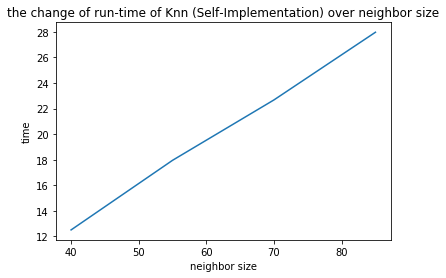

In [13]:
plt.title("the change of run-time of Knn (Self-Implementation) over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("time")
sns.lineplot(neighbor_size, knn_time, palette="tab10")

The running time increases as k increases.

### Mean_Absolute _Error (MAE) & Root Mean Squared Error (RMSE)
#### Primary accuracy metric : MAE

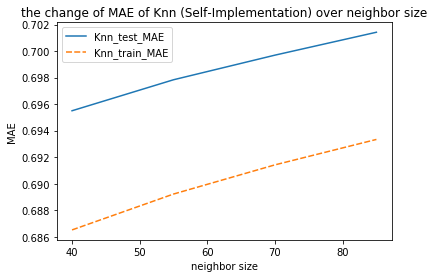

In [14]:
Knn_MAE = pd.DataFrame(np.column_stack([knn_test_mae, knn_train_mae]),columns=['Knn_test_MAE', 'Knn_train_MAE'])
Knn_MAE.index = neighbor_size
plt.title("the change of MAE of Knn (Self-Implementation) over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("MAE")
sns.lineplot(data = Knn_MAE, palette="tab10")

Observation :
The MAE of both train and test data increase as the neighbor size increases.

#### Secondary accuracy metric: RMSE

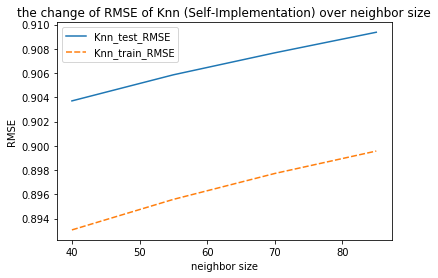

In [15]:
Knn_RMSE = pd.DataFrame(np.column_stack([knn_test_rmse, knn_train_rmse]),columns=['Knn_test_RMSE', 'Knn_train_RMSE'])
Knn_RMSE.index = neighbor_size
plt.title("the change of RMSE of Knn (Self-Implementation) over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("RMSE")
sns.lineplot(data = Knn_RMSE, palette="tab10")

Observation :
The RMSE of both train and test data increase as the neighbor size increases.

### How does Data size impact the accuracy of KNN (Self-implement)?

In [9]:
knn_size_result=[]
for n in new_size:
    knn_size_result.append(knn_cv(5,size=n))

In [11]:
knn_train_mae=[]
knn_train_rmse=[]
knn_test_mae=[]
knn_test_rmse=[]
knn_time=[]
for i in range(0,len(knn_size_result)):
    knn_train_mae.append(knn_size_result[i][0])
    knn_train_rmse.append(knn_size_result[i][1])
    knn_test_mae.append(knn_size_result[i][2])
    knn_test_rmse.append(knn_size_result[i][3])
    knn_time.append(knn_size_result[i][4])

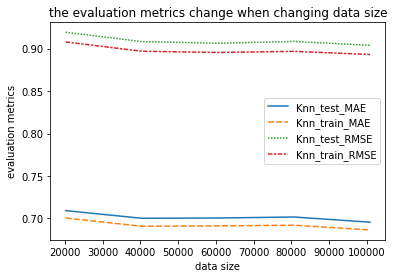

In [12]:
Knn_newsize_metrics = pd.DataFrame(np.column_stack([knn_test_mae, knn_train_mae,knn_test_rmse, knn_train_rmse]),
                   columns=['Knn_test_MAE', 'Knn_train_MAE','Knn_test_RMSE', 'Knn_train_RMSE'])
Knn_newsize_metrics.index = new_size
plt.title("the evaluation metrics change when changing data size")
plt.xlabel("data size")
plt.ylabel("evaluation metrics")
sns.lineplot(data = Knn_newsize_metrics, palette="tab10")

The MAE and RMSE go down as sample sizes increases. 

### How does sample size impact the run-time of KNN (self-implement)?

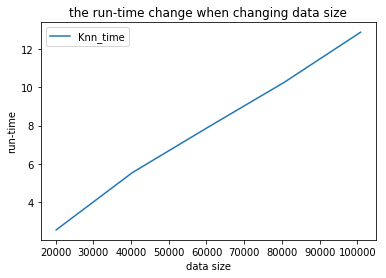

In [13]:
Knn_newsize_time = pd.DataFrame(knn_time,columns=['Knn_time'])
Knn_newsize_time.index = new_size
plt.title("the run-time change when changing data size")
plt.xlabel("data size")
plt.ylabel("run-time")
sns.lineplot(data = Knn_newsize_time, palette="tab10")

The fitting time goes up as the sample size going up.

## KNN by surprise with baseline added

In [30]:
Knn_time = []
Knn_train_MAE=[]
Knn_test_MAE=[]
Knn_train_RMSE=[]
Knn_test_RMSE=[]

for k in neighbor_size:    
    algo=KNNBaseline(k=k)
    c_v=cross_validate(algo, data,cv=10,return_train_measures =True)
    Knn_time.append(np.mean(c_v['fit_time']))
    Knn_train_MAE.append(np.mean(c_v['train_mae']))
    Knn_test_MAE.append(np.mean(c_v['test_mae']))
    Knn_train_RMSE.append(np.mean(c_v['train_rmse']))
    Knn_test_RMSE.append(np.mean(c_v['test_rmse']))
knn_result=[Knn_time,Knn_train_MAE,Knn_test_MAE,Knn_train_RMSE,Knn_test_RMSE]  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

## Evaluate Knn by surprise
### Fitting time vs. Neighbor size 

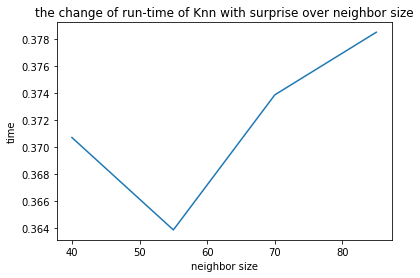

In [32]:
plt.title("the change of run-time of Knn with surprise over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("time")
sns.lineplot(neighbor_size, Knn_time, palette="tab10")

As shown above, when k is around 55, the fitting time is highest, meaning that the model is most complex at this neighbor size. The lowest fitting time is at k =75 approximately. While the run time of KNN without baseline is monotonically increasing by the increment of k. 


### Mean_Absolute _Error (MAE) & Root Mean Squared Error (RMSE)

#### Primary accuracy metric : MAE

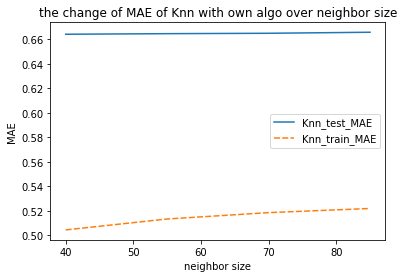

In [33]:
Knn_MAE = pd.DataFrame(np.column_stack([Knn_test_MAE, Knn_train_MAE]),columns=['Knn_test_MAE', 'Knn_train_MAE'])
Knn_MAE.index = neighbor_size
plt.title("the change of MAE of Knn with own algo over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("MAE")
sns.lineplot(data = Knn_MAE, palette="tab10")

The MAE is around 0.67 and it changes little by the increment of neighbor size.

#### Secondary accuracy metric: RMSE

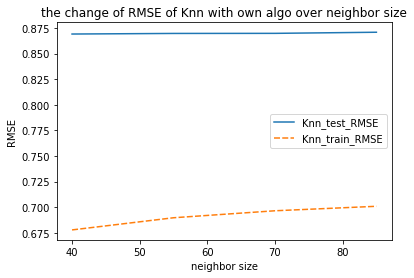

In [34]:
Knn_RMSE = pd.DataFrame(np.column_stack([Knn_test_RMSE, Knn_train_RMSE]),columns=['Knn_test_RMSE', 'Knn_train_RMSE'])
Knn_RMSE.index = neighbor_size
plt.title("the change of RMSE of Knn with own algo over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("RMSE")
sns.lineplot(data = Knn_RMSE, palette="tab10")

The RMSE is around 0.873 and it changes little by the increment of neighbor size.

#### The comparison of MAE and RMSE:

1. Since the errors are squared before taking averages, some large errors would be given higher weights. When large errors are undesirable, using RMSE to eveluate the model would be useful. RMSE increases with the variance of the frequency distribution of error magnitudes.

2. RMSE has a tendency to be increasingly larger than MAE as the test sample size increases. So this is a problem when comparing RMSE computed from different test sample sizes. 

#### The results of MAE and RMSE for our model:
We can use both MAE and RMSE to eveluate the model.

As the plot showing, MAE is much less than RMSE, which is normal. This also indicates that there are some large error outliers of the results. 

The large errors in the results means that our recommender predict completely wrong rating scores so that some users would get recommendations on movies that they don't like, which is unexpected from us. In this case, there is a approximately 0.2 difference between MAE and RMSE, which indicates that there is about 20% variance in the individual errors in the sample.




### How  does Data size impact the accuracy of KNN (by Surprise)?

Now we are trying to test how this model changes by the input data size.



In [35]:
#gridient search for optimal K value
param_grid = {'k': neighbor_size}
knn_gs=GridSearchCV(KNNBaseline,param_grid)
knn_gs.fit(data)

bestk = knn_gs.best_params['mae']['k']

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [36]:
knn_size_effect=[]
Knn_time = []
Knn_train_MAE=[]
Knn_test_MAE=[]
Knn_train_RMSE=[]
Knn_test_RMSE=[]
for n in new_size:
    new_df=df.sample(n=n)
    data=Dataset.load_from_df(new_df,reader=reader)
    algo=KNNBaseline(k=bestk)
    c_v=cross_validate(algo, data,cv=10,return_train_measures =True)
    Knn_time.append(np.mean(c_v['fit_time']))
    Knn_train_MAE.append(np.mean(c_v['train_mae']))
    Knn_test_MAE.append(np.mean(c_v['test_mae']))
    Knn_train_RMSE.append(np.mean(c_v['train_rmse']))
    Knn_test_RMSE.append(np.mean(c_v['test_rmse']))
knn_size_effect=[Knn_time,Knn_train_MAE,Knn_test_MAE,Knn_train_RMSE,Knn_test_RMSE]  


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8616  0.8719  0.8596  0.8647  0.8608  0.8734  0.8779  0.8746  0.8829  0.8626  0.8690  0.0078  
MAE (testset)     0.6581  0.6641  0.6550  0.6596  0.6628  0.6670  0.6697  0.6676  0.6756  0.6594  0.6639  0.0059  
RMSE (trainset)   0.6787  0.6771  0.6786  0.6779  0.6781  0.6771  0.6770  0.6777  0.6765  0.6785  0.6777  0.0007  
MAE (trainset)    0.5049  0.5043  0.5051  0.5046  0.5044  0.5

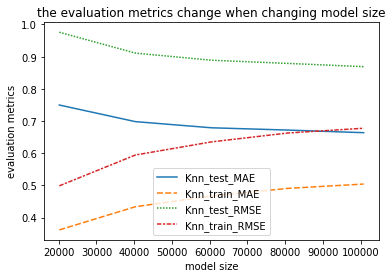

In [37]:
Knn_newsize_metrics = pd.DataFrame(np.column_stack([Knn_test_MAE, Knn_train_MAE,Knn_test_RMSE, Knn_train_RMSE]),
                   columns=['Knn_test_MAE', 'Knn_train_MAE','Knn_test_RMSE', 'Knn_train_RMSE'])
Knn_newsize_metrics.index = new_size
plt.title("the evaluation metrics change when changing data size")
plt.xlabel("data size")
plt.ylabel("evaluation metrics")
sns.lineplot(data = Knn_newsize_metrics, palette="tab10")

As the plot showing, the larger the sample size, the less MAE and RMSE.  But the MAE and RMSE of train set becomes larger as sample size increasing. 

The model overfits the train data when sample size is small. 

### How does Sample size impact the run-time of KNN (by Surprise)?

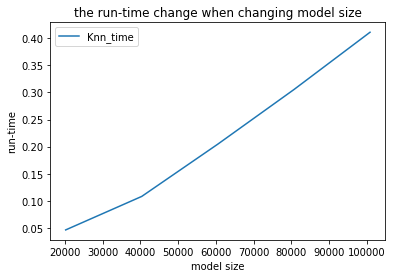

In [38]:
Knn_newsize_time = pd.DataFrame(Knn_time,columns=['Knn_time'])
Knn_newsize_time.index = new_size
plt.title("the run-time change when changing data size")
plt.xlabel("data size")
plt.ylabel("run-time")
sns.lineplot(data = Knn_newsize_time, palette="tab10")

The fitting time increases monotonically as sample size getting larger.

## Coverage

We have 610 users, 193609 items and 100836 ratings.


In [52]:
from collections import defaultdict
from surprise import Dataset

def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# train algorithm on the movielens dataset.
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = KNNBaseline()
algo.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [56]:
# predict ratings for all pairs (u, i) that are in the testset.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [57]:
def catalogcoverage(top_n):
    item_count = []
    for uid, user_ratings in top_n.items():
        top_k = [iid for (iid, _) in user_ratings]
        item_count.append(top_k)
    item_count = list(itertools.chain(*item_count))
    item_count = list(set(item_count))
    cc = len(item_count)/193609
    return cc

In [58]:
top_k = [10,40,70,100,130,160]
cc = []
for k in top_k:
    top_n = get_top_n(predictions, n=k)
    cc.append(catalogcoverage(top_n))

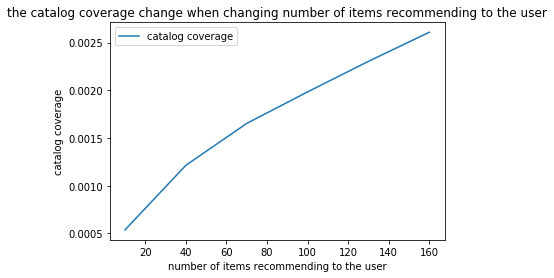

In [59]:
Knn_cc = pd.DataFrame(cc,columns=['catalog coverage'])
Knn_cc.index = top_k
plt.title("the catalog coverage change when changing number of items recommending to the user")
plt.xlabel("number of items recommending to the user")
plt.ylabel("catalog coverage")
sns.lineplot(data = Knn_cc, palette="tab10")

## Conclusions on KNN:

* The MAE and RMSE is not bad if we choose a larger data set.
* KNN is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

     * cold-start problem
     * It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
     * It tends to recommend popular items.


# Model-Based Collaborative Filtering
## NMF(Self-Implementation)

In [14]:
def update_matrix_fast(U,V,X_list,gamma_U_params):
    #lambda_u -> u_{i,:} -> x_ij <- (v^*)_{j,:} <- lambda_v
    #Multiplicative method 
    A,B = gamma_U_params['a'],gamma_U_params['b']
    m,d = U.shape
    _,n = V.shape
    n_obs = X_list.shape[0]
    UV_sp = np.zeros(n_obs)
    ind_i = X_list[:,0].astype('int')
    ind_j = X_list[:,1].astype('int')
    UV_sp = np.sum(U[ind_i,:]*(V[:,ind_j].T),axis=1)
    X_UV = spsp.csc_matrix((X_list[:,-1]/UV_sp,(ind_i,ind_j)),shape = (m,n))#gradient
    M = spsp.csc_matrix((np.ones(n_obs),(ind_i,ind_j)),shape = (m,n))
    part1 = (A+np.multiply(U,(X_UV@(V.T))))
    part2 = (A/B+M@(V.T))
    U_new = part1/part2
    return(U_new)

def list_to_mat(data,dims):
    #parse data into matrix
    m,n = dims
    n_obs = len(data[:,0])
    out1 = np.zeros((m,n))
    out2 = np.zeros((m,n))
    for ind in range(n_obs):
        i,j = data[ind,:2]
        i = int(i)
        j = int(j)
        out1[i,j] = data[ind,-1]
        out2[i,j] = 1   
    return(out1,out2)

def rand_col_init(X,d):
    #random column initialization as given in Langville 2014
    m,n = X.shape
    shuffled_n = list(range(n))
    np.random.shuffle(shuffled_n)
    U = np.zeros((m,d))
    set_size = int(m/d)
    for i in range(d):#shuffle col for U as sum of random cols(of size m/d) in X. This will compress n into d col randomly
        try:
            U[:,i] = np.sum(X[:,shuffled_n[int(i*set_size):int((i+1)*set_size)]],axis = 1)
        except IndexError:
            U[:,i] = np.sum(X[:,shuffled_n[int(i*set_size):]],axis = 1)
    
    for i in range(d):#check if the whole col has 0. replace it of random variable from uniform dist.
        bool_slice = U[:,i] == 0
        n_neq0 = sum(bool_slice)
        U[bool_slice,i] = spst.uniform.rvs(0,5,size = n_neq0)    
    return(U)

In [15]:
def Poisson_pmf(data,dims,factors,U_params={'a':1,'b':1}, V_params={'a':1,'b':1}, T=100):
    m,n = dims
    d = factors
    n_obs = len(data[:,0])    
    data_T = data[:,[1,0,2]]    
    mat_data, mat_mask = list_to_mat(data,dims)
    U_0=rand_col_init(mat_data,d)
    V_0=rand_col_init(mat_data.T,d).T
    U = U_0
    V = V_0
    for t in range(T):        
        U = update_matrix_fast(U,V,data,U_params)
        V = update_matrix_fast(V.T,U.T,data_T,V_params).T        
    return(U,V)

In [16]:
def predict(test_set,U,V):
    i_obs = test_set[:,0].astype('int')
    j_obs = test_set[:,1].astype('int')
    UV_obs = np.sum(U[i_obs,:]*V[:,j_obs].T,axis=1)
    diff = (test_set[:,-1]-UV_obs)
    return(np.mean(np.abs(diff)),(np.mean(diff**2))**0.5)

def nmf_cv(n_splits=5,factors=15,size=origin_size):
    df=pd.read_csv('./ml-latest-small/ratings.csv')
    df=df.iloc[:size]
    ratings = df.values
    m,n = int(ratings[:,0].max()+1),int(ratings[:,1].max()+1)
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 1)
    nmf_train_mae=[]
    nmf_train_mrse=[]
    nmf_test_mae=[]
    nmf_test_mrse=[]
    nmf_time=[]
    for  tr,ts in kf.split(df):
        start = tm.time()
        train=df.iloc[tr].values
        test=df.iloc[ts].values
        train[:,:2] -= 1
        train = train[:,:-1]
        test[:,:2] -= 1
        test = test[:,:-1]
        U,V=Poisson_pmf(train,(m,n),factors,T=100)
        ts_mae,ts_mrse=predict(test,U,V)
        tr_mae,tr_mrse=predict(train,U,V)
        end = tm.time()
        nmf_train_mae.append(tr_mae)
        nmf_train_mrse.append(tr_mrse)
        nmf_test_mae.append(ts_mae)
        nmf_test_mrse.append(ts_mrse)
        nmf_time.append(end-start)
    return [np.mean(nmf_train_mae),np.mean(nmf_train_mrse),
            np.mean(nmf_test_mae),np.mean(nmf_test_mrse),
            np.mean(nmf_time)]

In [11]:
latent_dimensions=np.arange(2,20,5)
nmf_result=[]
for d in latent_dimensions:
    nmf_result.append(nmf_cv(factors=d))

In [12]:
nmf_result

[[0.5889375409692416,
  0.7723765017214592,
  0.6742074474795985,
  0.88023950643188,
  4.036520719528198],
 [0.5409264984771827,
  0.7061217098435877,
  0.6735395677908395,
  0.8822570375542412,
  7.216719388961792],
 [0.5552511439577368,
  0.7299650872423525,
  0.6702769440652661,
  0.8803789889562538,
  10.391195964813232],
 [0.5938639065012299,
  0.7826008433495002,
  0.6809962875303553,
  0.8968260760772571,
  13.51186203956604]]

## Evaluate NMF (Self-Implementation)

In [15]:
nmf_train_mae=[]
nmf_train_rmse=[]
nmf_test_mae=[]
nmf_test_rmse=[]
nmf_time=[]
for i in range(0,len(nmf_result)):
    nmf_train_mae.append(nmf_result[i][0])
    nmf_train_rmse.append(nmf_result[i][1])
    nmf_test_mae.append(nmf_result[i][2])
    nmf_test_rmse.append(nmf_result[i][3])
    nmf_time.append(nmf_result[i][4])

### Fitting time vs. latent dimensions

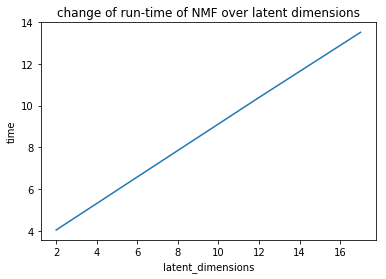

In [22]:
plt.title("change of run-time of NMF over latent dimensions")
plt.xlabel("latent_dimensions")
plt.ylabel("time")
sns.lineplot(latent_dimensions, nmf_time, palette="tab10")

The higher the latent dimensions, the slower the fitting time of the model since the model gets more complex.

### Mean_Absolute _Error (MAE) & Root Mean Squared Error (RMSE)
#### Primary accuracy metric : MAE

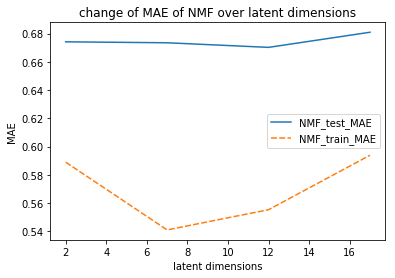

In [24]:
NMF_MAE = pd.DataFrame(np.column_stack([nmf_test_mae, nmf_train_mae]),columns=['NMF_test_MAE', 'NMF_train_MAE'])
NMF_MAE.index = latent_dimensions
plt.title("change of MAE of NMF over latent dimensions")
plt.xlabel("latent dimensions")
plt.ylabel("MAE")
sns.lineplot(data = NMF_MAE, palette="tab10")

MAE first decreases as latent dimensions increase. Then MAE increases with the increment of latent dimensions. 

The lowest MAE occurs at latent dimension = 12

#### Secondary accuracy metric: RMSE

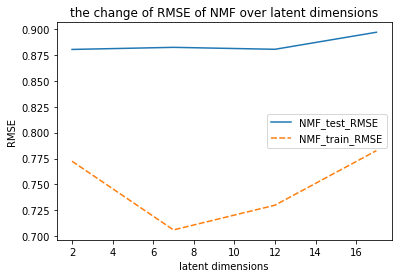

In [25]:
NMF_RMSE = pd.DataFrame(np.column_stack([nmf_test_rmse, nmf_train_rmse]),columns=['NMF_test_RMSE', 'NMF_train_RMSE'])
NMF_RMSE.index = latent_dimensions
plt.title("the change of RMSE of NMF over latent dimensions")
plt.xlabel("latent dimensions")
plt.ylabel("RMSE")
sns.lineplot(data = NMF_RMSE, palette="tab10")

The trend of RMSE by latent dimensions is similar with MAE. But the RMSE are lower at both latent dimension =2 and =12 than other values of latent dimension. 

### How does Sample size impact the accuracy of NMF?

In [18]:
nmf_size_result=[]
for n in new_size:
    nmf_size_result.append(nmf_cv(factors=7,size=n))

In [19]:
nmf_train_mae=[]
nmf_train_rmse=[]
nmf_test_mae=[]
nmf_test_rmse=[]
nmf_time=[]
for i in range(0,len(nmf_size_result)):
    nmf_train_mae.append(nmf_size_result[i][0])
    nmf_train_rmse.append(nmf_size_result[i][1])
    nmf_test_mae.append(nmf_size_result[i][2])
    nmf_test_rmse.append(nmf_size_result[i][3])
    nmf_time.append(nmf_size_result[i][4])

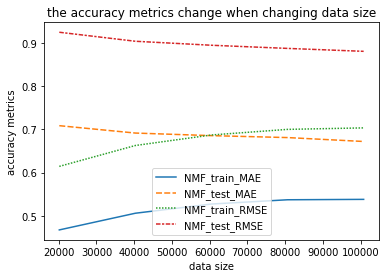

In [20]:
nmf_newsize_metrics = pd.DataFrame(np.column_stack([nmf_train_mae, nmf_test_mae,nmf_train_rmse, nmf_test_rmse]),
                   columns=['NMF_train_MAE', 'NMF_test_MAE','NMF_train_RMSE', 'NMF_test_RMSE'])
nmf_newsize_metrics.index = new_size
plt.title("the accuracy metrics change when changing data size")
plt.xlabel("data size")
plt.ylabel("accuracy metrics")
sns.lineplot(data = nmf_newsize_metrics, palette="tab10")

When sample size is small, the model overfit the train data. 

### How does Data size impact the run-time of NMF?

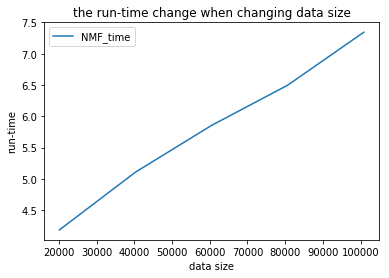

In [21]:
nmf_newsize_time = pd.DataFrame(nmf_time,columns=['NMF_time'])
nmf_newsize_time.index = new_size
plt.title("the run-time change when changing data size")
plt.xlabel("data size")
plt.ylabel("run-time")
sns.lineplot(data = nmf_newsize_time, palette="tab10")

As the sample size increases, the model is getting more complex. 

### Conclusions:
* The average MAE of test data is around 0.67, which is similar with the results from KNN.
* However, NMF can capture the multi cause confounding factors that influences the rating scores.



# SVD by surprise

In [11]:
learning_rate=np.arange(0.001,0.05,0.01)
regularization=np.arange(0.01,0.1,0.03)
n_factors=np.arange(50,200,50)
n_epochs=np.arange(10,100,20)

svd_result=[]
for lr in learning_rate:
    SVD_time = []
    SVD_train_MAE=[]
    SVD_test_MAE=[]
    SVD_train_RMSE=[]
    SVD_test_RMSE=[]
    
    for reg in regularization:
        algo=SVD(n_epochs =50,lr_all=lr,reg_all=reg)
        c_v=cross_validate(algo, data,cv=5,return_train_measures =True)
        SVD_time.append(np.mean(c_v['fit_time']))
        SVD_train_MAE.append(np.mean(c_v['train_mae']))
        SVD_test_MAE.append(np.mean(c_v['test_mae']))
        SVD_train_RMSE.append(np.mean(c_v['train_rmse']))
        SVD_test_RMSE.append(np.mean(c_v['test_rmse']))
    svd_result.append([SVD_time,SVD_train_MAE,SVD_test_MAE,SVD_train_RMSE,SVD_test_RMSE])


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8811  0.8836  0.8811  0.8836  0.8858  0.8830  0.0018  
MAE (testset)     0.6799  0.6813  0.6787  0.6797  0.6826  0.6804  0.0014  
RMSE (trainset)   0.7619  0.7643  0.7643  0.7640  0.7633  0.7636  0.0009  
MAE (trainset)    0.5889  0.5901  0.5908  0.5904  0.5893  0.5899  0.0007  
Fit time          12.26   12.53   12.48   12.50   12.47   12.45   0.09    
Test time         0.26    0.14    0.14    0.15    0.21    0.18    0.05    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8821  0.8810  0.8825  0.8769  0.8767  0.8799  0.0025  
MAE (testset)     0.6821  0.6796  0.6803  0.6750  0.6735  0.6781  0.0033  
RMSE (trainset)   0.7920  0.7913  0.7926  0.7918  0.7946  0.7925  0.0012  
MAE (trainset)    0.6116  0.6114  0.6125  0.6123  0.6141  0.6124  0

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8587  0.8412  0.8604  0.8599  0.8472  0.8535  0.0078  
MAE (testset)     0.6580  0.6492  0.6567  0.6583  0.6471  0.6539  0.0048  
RMSE (trainset)   0.4696  0.4694  0.4692  0.4703  0.4696  0.4696  0.0004  
MAE (trainset)    0.3536  0.3538  0.3543  0.3548  0.3535  0.3540  0.0005  
Fit time          12.70   12.53   12.75   13.66   13.34   13.00   0.43    
Test time         0.15    0.14    0.23    0.15    0.15    0.16    0.03    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8942  0.8869  0.8809  0.8904  0.8871  0.8879  0.0044  
MAE (testset)     0.6881  0.6798  0.6756  0.6848  0.6806  0.6818  0.0043  
RMSE (trainset)   0.0874  0.0877  0.0884  0.0875  0.0895  0.0881  0.0008  
MAE (trainset)    0.0530  0.0534  0.0540  0.0531  0.0554  0.0538  0

## Evaluate SVD by surprise

In [12]:
svd_time = []
svd_train_MAE = []
svd_test_MAE = []
svd_train_RMSE = []
svd_test_RMSE = []
for row in svd_result:
    svd_time.append(row[0])
    svd_train_MAE.append(row[1])
    svd_test_MAE.append(row[2])
    svd_train_RMSE.append(row[3])
    svd_test_RMSE.append(row[4])

### Fitting time vs. hyper-parameters

In [13]:
svd_time = pd.DataFrame(svd_time)
svd_time.index = learning_rate.round(3)
svd_time.index.name = 'learning_rate'
svd_time.columns = regularization.round(2)
svd_time.columns.name = 'regularization'

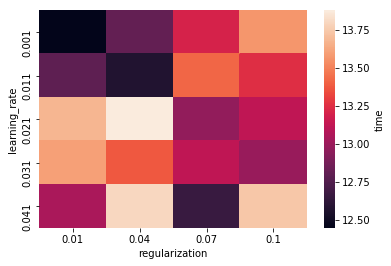

In [14]:
sns.heatmap(data = svd_time,cbar_kws={'label': 'time'})

As the plot showing, there is no pattern of relationships between fitting time and learning rate at a fixed regularization. The SVD model's fitting time has no strong relations with the learning rate and regularization.

### Mean_Absolute _Error (MAE) & Root Mean Squared Error (RMSE)
#### primary accuracy metric : MAE

In [15]:
svd_test_MAE = pd.DataFrame(svd_test_MAE)
svd_test_MAE.index = learning_rate.round(3)
svd_test_MAE.index.name = 'learning_rate'
svd_test_MAE.columns = regularization.round(2)
svd_test_MAE.columns.name = 'regularization'

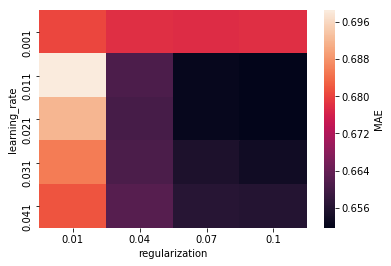

In [16]:
sns.heatmap(data = svd_test_MAE,cbar_kws={'label': 'MAE'})

As we can clearly see in the plot, increasing learning rate causes lower MAE on test data at each level of regularization. The heavier weight of the regularization, the lower the MAE.

#### secondary accuracy metric : RMSE

In [17]:
svd_test_RMSE = pd.DataFrame(svd_test_RMSE)
svd_test_RMSE.index = learning_rate.round(3)
svd_test_RMSE.index.name = 'learning_rate'
svd_test_RMSE.columns = regularization.round(2)
svd_test_RMSE.columns.name = 'regularization'

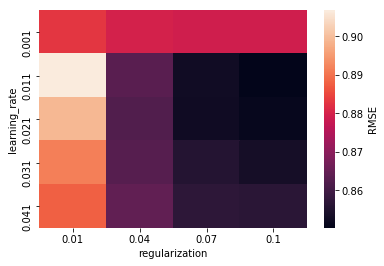

In [18]:
sns.heatmap(data = svd_test_RMSE,cbar_kws={'label': 'RMSE'})

The trend of RMSE is similar with MAE. RMSE goes down as more regularization is enforced.

### How does Data size impact the accuracy of SVD?

In [19]:
param_grid = {'lr_all': learning_rate,'reg_all':regularization}
svd_gs=GridSearchCV(SVD,param_grid)
svd_gs.fit(data)

bestlr = svd_gs.best_params['mae']['lr_all']
bestreg=svd_gs.best_params['mae']['reg_all']
print(bestlr,bestreg)

KeyboardInterrupt: 

In [ ]:
SVD_time = []
SVD_train_MAE=[]
SVD_test_MAE=[]
SVD_train_RMSE=[]
SVD_test_RMSE=[]
SVD_size_effect=[]
for n in new_size:
    new_df=df.sample(n=n)
    data=Dataset.load_from_df(new_df,reader=reader)
    algo=SVD(n_epochs =50,lr_all=bestlr,reg_all=bestreg)
    c_v=cross_validate(algo, data,cv=5,return_train_measures =True)
    SVD_time.append(np.mean(c_v['fit_time']))
    SVD_train_MAE.append(np.mean(c_v['train_mae']))
    SVD_test_MAE.append(np.mean(c_v['test_mae']))
    SVD_train_RMSE.append(np.mean(c_v['train_rmse']))
    SVD_test_RMSE.append(np.mean(c_v['test_rmse']))
SVD_size_effect.append([SVD_time,SVD_train_MAE,SVD_test_MAE,SVD_train_RMSE,SVD_test_RMSE])

In [342]:
%store SVD_size_effect

Stored 'SVD_size_effect' (list)


In [71]:
SVD_size_effect

[[2.825703763961792,
  5.547080683708191,
  8.237026929855347,
  11.580831670761109,
  14.405395221710204],
 [0.25359704368156943,
  0.29103409744674347,
  0.31899733066335634,
  0.34249580940766333,
  0.36291928616750707],
 [0.7025067628566097,
  0.6860331841677325,
  0.6702736199437369,
  0.6575217320661327,
  0.6459514326134578],
 [0.3227840906876074,
  0.37227287430596406,
  0.40943551726940647,
  0.441195335118295,
  0.46759323218033017],
 [0.9126430363816462,
  0.8927526186365793,
  0.8721704667860543,
  0.8586235960773985,
  0.8441885144961937]]

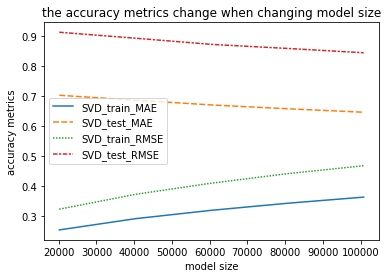

In [74]:
svd_newsize_metrics = pd.DataFrame(np.column_stack([SVD_train_MAE, SVD_test_MAE,SVD_train_RMSE, SVD_test_RMSE]),
                   columns=['SVD_train_MAE', 'SVD_test_MAE','SVD_train_RMSE', 'SVD_test_RMSE'])
svd_newsize_metrics.index = new_size
plt.title("the accuracy metrics change when changing data size")
plt.xlabel("data size")
plt.ylabel("accuracy metrics")
sns.lineplot(data = svd_newsize_metrics, palette="tab10")

The model overfits the training data very easily when the training set is small. 
MAE and RMSE is getting smaller when sample size increases.

### How does Data size impact the run-time of SVD?

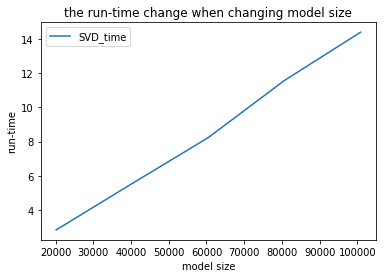

In [47]:
SVD_newsize_time = pd.DataFrame(SVD_time,columns=['SVD_time'])
SVD_newsize_time.index = new_size
plt.title("the run-time change when changing data size")
plt.xlabel("data size")
plt.ylabel("run-time")
sns.lineplot(data = SVD_newsize_time, palette="tab10")

The smaller the sample size, the faster the model fits. 

## Coverage on training and test data

In [41]:
from collections import defaultdict
from surprise import Dataset

def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# train algorithm on the movielens dataset.
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [43]:
top_k = [10,40,70,100,130,160]
cc = []
for k in top_k:
    top_n = get_top_n(predictions, n=k)
    cc.append(catalogcoverage(top_n))

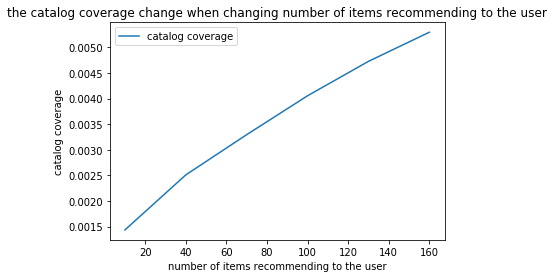

In [45]:
SVD_cc = pd.DataFrame(cc,columns=['catalog coverage'])
SVD_cc.index = top_k
plt.title("the catalog coverage change when changing number of items recommending to the user")
plt.xlabel("number of items recommending to the user")
plt.ylabel("catalog coverage")
sns.lineplot(data = SVD_cc, palette="tab10")

### Conclusions on SVD model:
#### Effect of hyper-parameters:
* Running(fitting) time: The learning rate and regularization does not affect the fitting time but sample size does.
* SVD model tends to overfit train data when sample size is small.
* MAE and RMSE goes down as more weights on regularization and under less learning rates.
#### Drawbacks of SVD：
* Large number of free parameters which makes finding a good set of parameters that will work good for all cases is very hard.




# Conclusions:

### Factors that matter in a recommendation algorithms in HW2:
#### * Accuracy: 
       * It matters that the accuracy of a recommender is good, since we wouldn't like the users receives a recommendation that he don't like, which would cause the reduction of engagement of users.
#### * Fitting time:
       * In a real world project, the dataset is usually large. It's significant that the fitting time is as efficient as possible without hurt of performance.

#### * The best parameters:
       * In order to have good performance, we need to train the model by finding a good set of parameters.
       * For KNN, the best neighbor size is 
       * For SVD, the 
       * For NMF
       

#### In order to make business decision on choosing a recommender, we need to leverage these three factors to choose our models.

* Accuracy: The average MAE of KNN, NMF, and SVD in this case are all around 0.67.
* Fitting time: 
 
      When sample size is small (20000) : The fitting time of KNN and SVD are faster than NMF.
      When sample size gets larger (100000) : The fitting time of NMF are less than other two models.
* Hyper-parameters:
      SVD has lots of free parameters. If we are facing a large dataset, it will take lots of time and efforts to find a set of parameters that best fit the model. 
      For KNN, since the dataset we use is small, the MAE or RMSE does not change much when neighbor size gets larger. For a real world problem with a large or a sparse dataset, it's hard to find users that have rated the same items.
      
